In [3]:
import warnings
import pandas as pd
import numpy as np
import pandas_profiling
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
%matplotlib inline

In [4]:
application_train = pd.read_csv(r"D:\Downloads\NEU\NAM 3 KI 1\Visualization\GITHUB FINAL PROJECT\Credit-Risk-Analysis\dseb-63-data-preparation-final-project\dseb63_final_project_DP_dataset\dseb63_final_project_DP_dataset\dseb63_application_train.csv")
application_test = pd.read_csv(r"D:\Downloads\NEU\NAM 3 KI 1\Visualization\GITHUB FINAL PROJECT\Credit-Risk-Analysis\dseb-63-data-preparation-final-project\dseb63_final_project_DP_dataset\dseb63_final_project_DP_dataset\dseb63_application_test.csv")
ins_pay = pd.read_csv(r"D:\Downloads\NEU\NAM 3 KI 1\Visualization\GITHUB FINAL PROJECT\Credit-Risk-Analysis\dseb-63-data-preparation-final-project\dseb63_final_project_DP_dataset\dseb63_final_project_DP_dataset\dseb63_installments_payments.csv")
#ins_pay_profile = ins_pay.profile_report(title="Install Paayment dataset report")
#ins_pay_profile 

In [5]:
print(f'The shape of installments_payments.csv is: {ins_pay.shape}')
print(f'Number of unique SK_ID_PREV in installments_payments.csv are: {len(ins_pay.SK_ID_PREV.unique())}')
print(f'Number of unique SK_ID_CURR in installments_payments.csv are: {len(ins_pay.SK_ID_CURR.unique())}')
print(f'Number of overlapping SK_ID_CURR in application_train.csv and installments_payments.csv are: {len(set(application_train.SK_ID_CURR.unique()).intersection(set(ins_pay.SK_ID_CURR.unique())))}')
print(f'Number of overlapping SK_ID_CURR in application_test.csv and installments_payments.csv are: {len(set(application_test.SK_ID_CURR.unique()).intersection(set(ins_pay.SK_ID_CURR.unique())))}')
print(f'Number of duplicate values in installments_payments: {ins_pay.shape[0] - ins_pay.duplicated().shape[0]}')

The shape of installments_payments.csv is: (7744758, 8)
Number of unique SK_ID_PREV in installments_payments.csv are: 549020
Number of unique SK_ID_CURR in installments_payments.csv are: 180734
Number of overlapping SK_ID_CURR in application_train.csv and installments_payments.csv are: 144408
Number of overlapping SK_ID_CURR in application_test.csv and installments_payments.csv are: 36325
Number of duplicate values in installments_payments: 0


In [6]:
def check_missed_values(df):
    df_null_percentage = df.isnull().sum() / df.shape[0] * 100
    df_null_percentage = df_null_percentage.drop(df_null_percentage[df_null_percentage == 0].index).sort_values(ascending= False).reset_index()
    df_null_percentage.columns = ["Feature", "Percentage"]
    return df_null_percentage

check_missed_values(ins_pay)

,Feature,Percentage
0,DAYS_ENTRY_PAYMENT,0.021163
1,AMT_PAYMENT,0.021163
2,AMT_INSTALMENT,0.000013
3,SK_ID_CURR,0.000013


In [7]:
ins_pay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7744758 entries, 0 to 7744757
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   NUM_INSTALMENT_VERSION  float64
 2   NUM_INSTALMENT_NUMBER   int64  
 3   DAYS_INSTALMENT         float64
 4   DAYS_ENTRY_PAYMENT      float64
 5   AMT_INSTALMENT          float64
 6   AMT_PAYMENT             float64
 7   SK_ID_CURR              float64
dtypes: float64(6), int64(2)
memory usage: 472.7 MB


#### OBSERVATION from instalment_payment.csv

- There are ~13605401 observations with 8 features list below:
    - SK_ID_PREV: ID of previous credit in Home Credit related to loan in our sample
    - SK_ID_CURR: ID of loan in our sample
    - NUM_INSTALMENT_VERSION: Version of installment calendar (0 is for credit card) of previous credit. Change of installment version from month to month signifies that some parameter of payment calendar has changed

    - NUM_INSTALMENT_NUMBER : On which installment we observe payment (lan tra gop so bao nhieu)

    - DAYS_INSTALMENT: When the installment of previous credit was supposed to be paid (relative to application date of current loan),time only relative to the application (ngay tra gop)
    - DAYS_ENTRY_PAYMENT: When was the installments of previous credit paid actually (ngay ma khach hang that su tra)
    - AMT_INSTALMENT: What was the prescribed installment amount of previous credit on this installment (luong tien tra gop dang ra khach hang phai tra)
    - AMT_PAYMENT: What the client actually paid on previous credit on this installment ( luong tien tra gop ma khach hang that su tra)

## EDA

### Merge the TARGETS from application_train to ins_pay

In [8]:
ins_pay_merge = pd.merge(application_train[["SK_ID_CURR", "TARGET"]], ins_pay, how='left', on=['SK_ID_CURR'])
#ins_pay_merge_profile = ins_pay_merge.profile_report(title="installment_payment merged dataset report")
#ins_pay_merge_profile

#### Univariate Analysis : Num_Instalment_Number

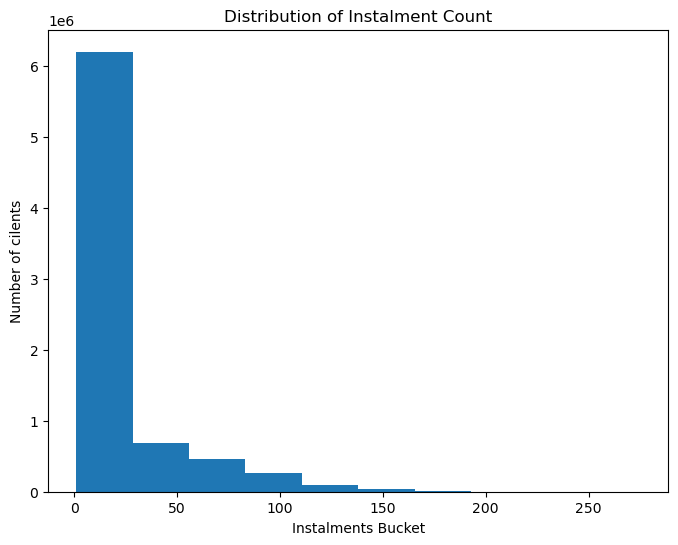

In [9]:
# Create a bar plot
plt.figure(figsize=(8, 6))
plt.hist(ins_pay['NUM_INSTALMENT_NUMBER'].values, bins=10)

# Set plot labels and title
plt.ylabel("Number of cilents")
plt.xlabel('Instalments Bucket')
plt.title("Distribution of Instalment Count")


# Show the plot
plt.show()

- Observations :
Most of the clients complete their instalment payment before 25 months.

#### Univariate Analysis : Amt_Payment

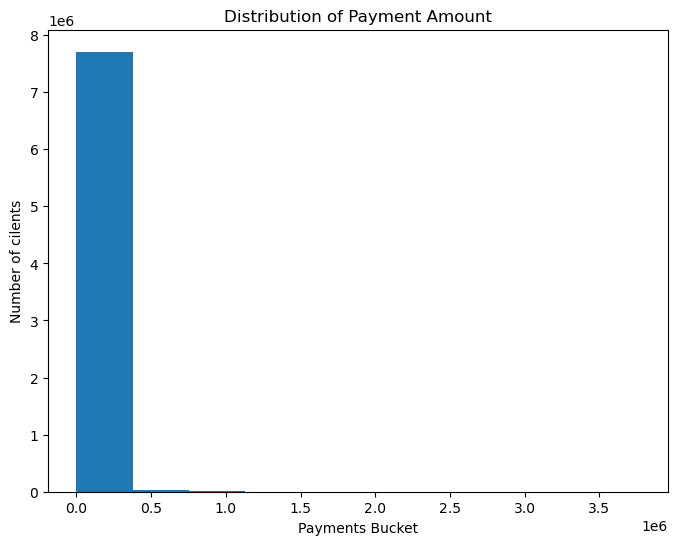

In [10]:
# Create a bar plot
plt.figure(figsize=(8, 6))
plt.hist(ins_pay['AMT_PAYMENT'].values, bins=10)

# Set plot labels and title
plt.ylabel("Number of cilents")
plt.xlabel('Payments Bucket')
plt.title("Distribution of Payment Amount")


# Show the plot
plt.show()

-  Observations :
Most of the clients paid less than 5 lakh on previous credit on the same installment.

### Bivariate Analysis

In [11]:
def plot_continuous_variables(data, column_name, plots = ['distplot', 'CDF', 'box', 'violin'], scale_limits = None, figsize = (20,8), histogram = True, log_scale = False):
    
    '''
    Function to plot continuous variables distribution
    
    Inputs:
        data: DataFrame
            The DataFrame from which to plot.
        column_name: str
            Column's name whose distribution is to be plotted.
        plots: list, default = ['distplot', 'CDF', box', 'violin']
            List of plots to plot for Continuous Variable.
        scale_limits: tuple (left, right), default = None
            To control the limits of values to be plotted in case of outliers.
        figsize: tuple, default = (20,8)
            Size of the figure to be plotted.
        histogram: bool, default = True
            Whether to plot histogram along with distplot or not.
        log_scale: bool, default = False
            Whether to use log-scale for variables with outlying points.
    '''

    data_to_plot = data.copy()
    if scale_limits:
        #taking only the data within the specified limits
        data_to_plot[column_name] = data[column_name][(data[column_name] > scale_limits[0]) & (data[column_name] < scale_limits[1])]

    number_of_subplots = len(plots)
    plt.figure(figsize = figsize)
    sns.set_style('whitegrid')
    
    for i, ele in enumerate(plots):
        plt.subplot(1, number_of_subplots, i + 1)
        plt.subplots_adjust(wspace=0.25)
        
        if ele == 'CDF':
            #making the percentile DataFrame for both positive and negative Class Labels
            percentile_values_0 = data_to_plot[data_to_plot.TARGET == 0][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_0['Percentile'] = [ele / (len(percentile_values_0)-1) for ele in range(len(percentile_values_0))]
            
            percentile_values_1 = data_to_plot[data_to_plot.TARGET == 1][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_1['Percentile'] = [ele / (len(percentile_values_1)-1) for ele in range(len(percentile_values_1))]
            
            plt.plot(percentile_values_0[column_name], percentile_values_0['Percentile'], color = 'red', label = 'Non-Defaulters')
            plt.plot(percentile_values_1[column_name], percentile_values_1['Percentile'], color = 'black', label = 'Defaulters')
            plt.xlabel(column_name)
            plt.ylabel('Probability')
            plt.title('CDF of {}'.format(column_name))
            plt.legend(fontsize = 'medium')
            if log_scale:
                plt.xscale('log')
                plt.xlabel(column_name + ' - (log-scale)')
            
        if ele == 'distplot':  
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 0].dropna(),
                         label='Non-Defaulters', hist = False, color='red')
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 1].dropna(),
                         label='Defaulters', hist = False, color='black')
            plt.xlabel(column_name)
            plt.ylabel('Probability Density')
            plt.legend(fontsize='medium')
            plt.title("Dist-Plot of {}".format(column_name))
            if log_scale:
                plt.xscale('log')
                plt.xlabel(f'{column_name} (log scale)')

        if ele == 'violin':  
            sns.violinplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Violin-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

        if ele == 'box':  
            sns.boxplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Box-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

    plt.show()

### Bivariate Analysis: DAYS_INSTALMENT vs DEFAULTER (TARGET=1)

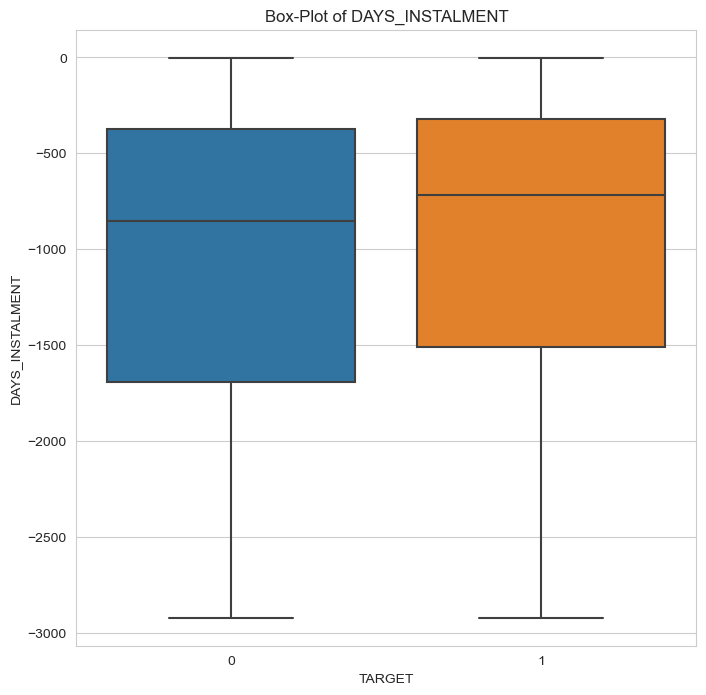

In [12]:
plot_continuous_variables(ins_pay_merge, 'DAYS_INSTALMENT', plots = ['box'], figsize = (8,8))

### Bivariate Analysis: DAYS_ENTRY_PAYMENT vs DEFAULTER (TARGET=1)

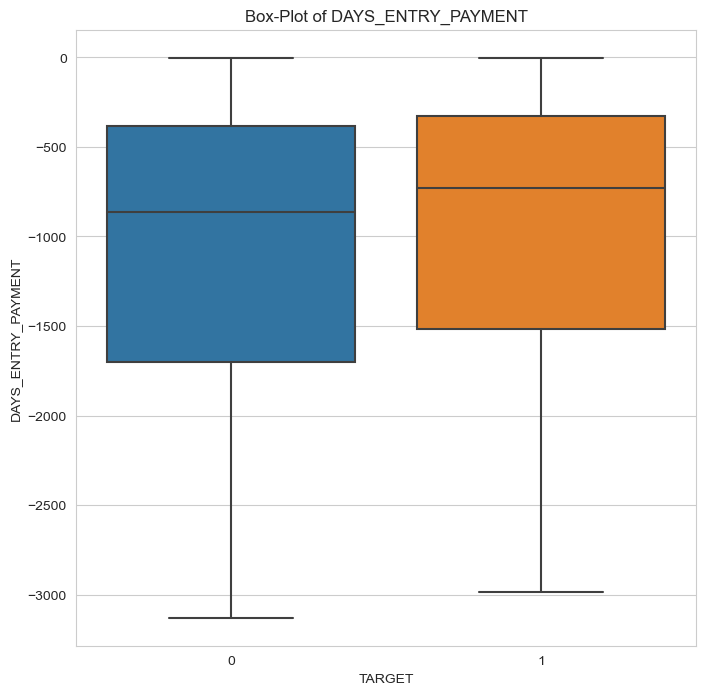

In [13]:
plot_continuous_variables(ins_pay_merge, 'DAYS_ENTRY_PAYMENT', plots = ['box'], figsize = (8,8))
